# Week 7 Practice

## Binomial Tree (CRR Tree)

The Binomial options pricing model approach has been widely used since it is able to handle a variety of conditions for which other models cannot easily be applied. This is largely because the BOPM is based on the description of an underlying instrument over a period of time rather than a single point.

In [1]:
import numpy as np
import os

The Binomial options pricing model approach has been widely used since it is able to handle a variety of conditions for which other models cannot easily be applied. This is largely because the BOPM is based on the description of an underlying instrument over a period of time rather than a single point.

### Data Input

Valuation is performed iteratively, starting at each of the final nodes (those that may be reached at the time of expiration), and then working backwards through the tree towards the first node (valuation date). The value computed at each stage is the value of the option at that point in time.

In [2]:
S0 = 100.0              # spot stock price
K = 100.0               # strike
T = 1.0                 # maturity 
r = 0.1                 # risk free rate 
sig = 0.2               # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 

### Step 1: Create the binomial price tree

The tree of prices is produced by working forward from valuation date to expiration.

At each step, it is assumed that the underlying instrument will move up or down by a specific factor ( u or d) per step of the tree (where, by definition, u ≥ 1 and 0 < d ≤ 1 ). So, if S is the current price, then in the next period the price will either be S_up = S * u or S_down = S * d.

In [3]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [4]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [5]:
S

array([[100.        , 112.24009024, 125.97837858, 141.39824581],
       [  0.        ,  89.09472523, 100.        , 112.24009024],
       [  0.        ,   0.        ,  79.37870064,  89.09472523],
       [  0.        ,   0.        ,   0.        ,  70.72223522]])

In [6]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.6176090164403981

### Step 2: Find option value at each final node

At each final node of the tree-i.e. at expiration of the option-the option value is simply its intrinsic, or exercise, value:
Max[(S_n-K),0] for a call option and Max[(K-S_n),0] for a put option, where K is the strike price and S_n is the spot price of the underlying asset at the n-th period.

In [7]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 10.90527477],
       [ 0.        ,  0.        ,  0.        , 29.27776478]])

### Step 3: Find option value at earlier nodes

Once the above step is complete, the option value is then found for each node, starting at the penultimate time step, and working back to the first node of the tree (the valuation date) where the calculated result is the value of the option.

#### European Option

In [8]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 4.15461967,  1.49175992,  0.        ,  0.        ],
       [ 0.        ,  8.82373471,  4.0333673 ,  0.        ],
       [ 0.        ,  0.        , 17.34290941, 10.90527477],
       [ 0.        ,  0.        ,  0.        , 29.27776478]])

In [9]:
print('European ' + payoff, str( V[0,0]))

European put 4.154619665678642


#### American Option

In [10]:
# for American Option
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
elif payoff =="put":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(K - S[i,j],np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
V

array([[ 4.92448707,  1.49175992,  0.        ,  0.        ],
       [ 0.        , 10.90527477,  4.0333673 ,  0.        ],
       [ 0.        ,  0.        , 20.62129936, 10.90527477],
       [ 0.        ,  0.        ,  0.        , 29.27776478]])

In [11]:
print('American ' + payoff, str( V[0,0]))

American put 4.924487073316837


## Monte Carlo Simulation

It still has one Python loop, namely over the time intervals. The other dimension is handled by vectorized code over all paths.

In [12]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [13]:
T = 1
r = 0.1
sigma = 0.2
S0 = 100
K = 100

In [14]:
S = mcs_simulation_np(1000)

In [15]:
S = np.transpose(S)
S

array([[100.        , 101.15351947, 100.809434  , ..., 124.89179792,
        124.53358233, 124.04872018],
       [100.        , 100.08168896, 100.44079187, ..., 116.83751953,
        117.04802196, 116.89711998],
       [100.        , 100.8719508 , 101.29236991, ...,  83.3312127 ,
         83.07527411,  81.87950336],
       ...,
       [100.        ,  99.74476535, 100.06269622, ...,  92.38047359,
         91.67057622,  92.12168911],
       [100.        , 100.96902688, 100.65750859, ..., 127.4051115 ,
        128.53394304, 127.89331081],
       [100.        , 100.61992397,  99.93706596, ..., 107.20330151,
        107.75666355, 107.31341993]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

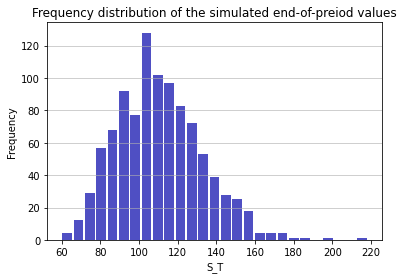

In [16]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [17]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 4.141378568423355


In [18]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 14.693559515704175
